In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import cellij
import numpy as np
import matplotlib.pyplot as plt

/Users/tim.treis/anaconda3/envs/spatialdata/envs/cellij/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
mdata = cellij._data.Importer().load_CLL()
mdata["mrna"]

AnnData object with n_obs × n_vars = 136 × 5000

In [4]:
model = cellij.models.MOFA(n_factors=50)
model.add_data(data=mdata, na_strategy="knn_by_obs")

In [5]:
model.fit(likelihood="Normal",  epochs=30)

Epoch      0:     6585073.78 	 | 
Training finished.


In [6]:
model.get_w(views=["mrna", "drugs"])

{'mrna': array([[-0.00367559, -0.06287721, -0.06734521, ..., -0.01466974,
          0.00595764, -0.00023815],
        [ 0.05280843, -0.03885657, -0.01379496, ...,  0.01106375,
          0.04633193, -0.03261178],
        [ 0.00216507, -0.05051252, -0.05973295, ..., -0.03770826,
         -0.01207996, -0.03470765],
        ...,
        [ 0.03971393, -0.07178452, -0.07149749, ..., -0.03075821,
          0.01985027, -0.03573732],
        [ 0.00085019, -0.03192764, -0.03632008, ..., -0.01168426,
          0.00409138, -0.00840682],
        [ 0.02245055, -0.06153488, -0.03362127, ..., -0.02213308,
          0.00880176, -0.00011443]], dtype=float32),
 'drugs': array([[-0.01329787, -0.02813593,  0.01128374, ..., -0.01298828,
         -0.0046294 , -0.02310077],
        [-0.02378661,  0.01052713, -0.01709233, ...,  0.02905579,
          0.01602341, -0.02183499],
        [-0.00796706, -0.0073652 , -0.00818322, ..., -0.00245732,
          0.01855883, -0.01290364],
        ...,
        [-0.00184432, 

In [7]:
model.save("mofa.pkl")

In [8]:
mofa = cellij.utils.load_model("mofa.pkl")

<AxesSubplot:>

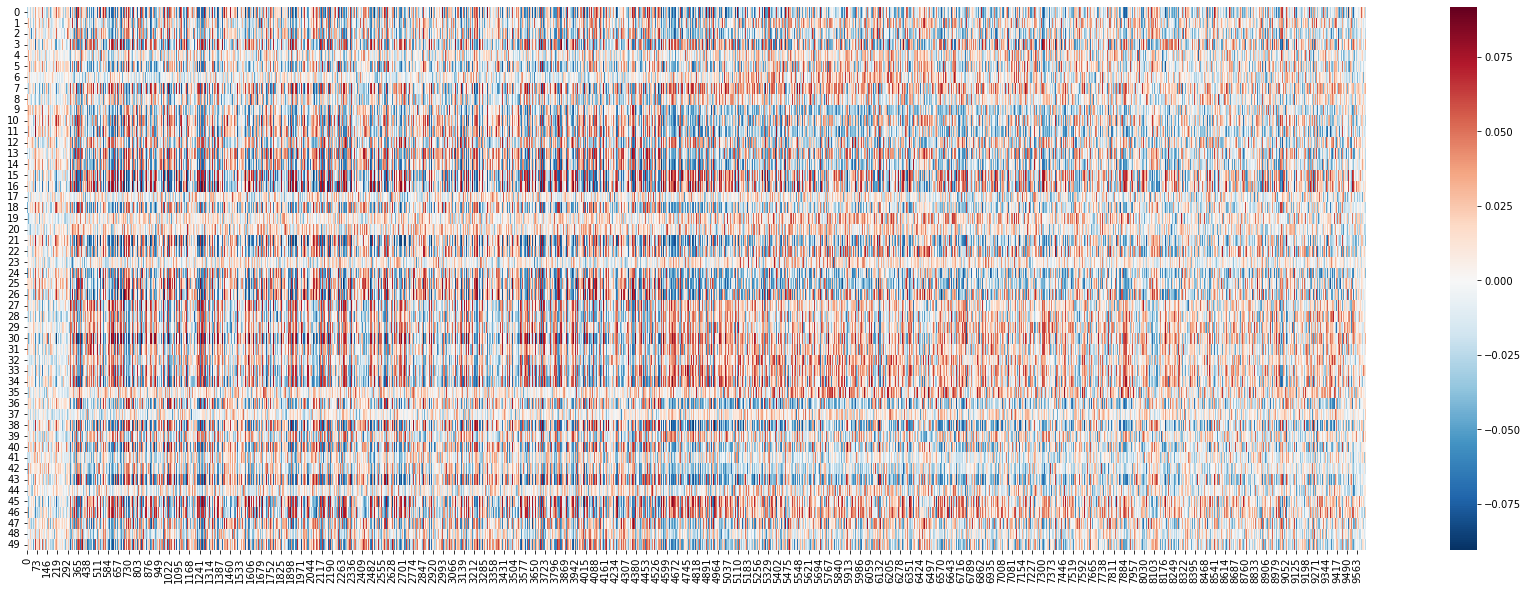

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(30, 10))
sns.heatmap(mofa.get_w(format="numpy"), center=0, cmap='RdBu_r')

In [10]:
w = model.get_w()
z = model.get_z()

print(w.shape, z.shape)

xhat = np.matmul(z,w.T)

fig, ax = plt.subplots(1, 2, figsize=(30, 10))
sns.heatmap(xhat, center=0, cmap='RdBu_r', ax=ax[0])
sns.heatmap(mdata["mrna"].X, center=0, cmap='RdBu_r', ax=ax[1])

torch.Size([50, 9627]) torch.Size([200, 50])


ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 9627 is different from 50)